# peak power minimization with picos


## introduction

In [1]:
import picos as pc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from truss import var, display #my package

I have created a Python package that is similar to Marek's matlab package. Let's consider the example truss in the Heidari's paper. First we create some constants then we implement the example truss.

In [2]:
E = 2.5e4 # young module
rho = 1. #density
m = 1. #total mass
omega = 15. #angular frequency of the loads

In [3]:
x = np.array([0,3]+[0,1,2,3]*2+[0,3])
y = np.array([0]*2+[-1]*4+[-2]*4+[-3]*2)
nodes = var.nodes(x,y)
nodes.set_kinematic([0,1])
n1=[0,0,1,1,2,2,2,3,3,4,4,4,4,5,6,6,7,7,8,8,9]
n2=[2,3,4,5,3,6,7,4,7,5,7,8,9,9,7,10,8,10,9,11,11]
elements = var.elements(n1,n2)

t = var.truss(nodes, elements)
t.set_density(rho)
t.set_module_young(E)

We can visualize it, since there is no value for the cross section aeras, we visualize only the topology with uniform cross section aera. Don't worry about the warnings. A node with cross means that it is fixed by kinematic condition.

/home/shenyuan/project/code/package/truss_exp/src/truss/display.py:13: UserWarning: value of cross section aera not specified, display with default value
  warnings.warn("value of cross section aera not specified, display with default value")


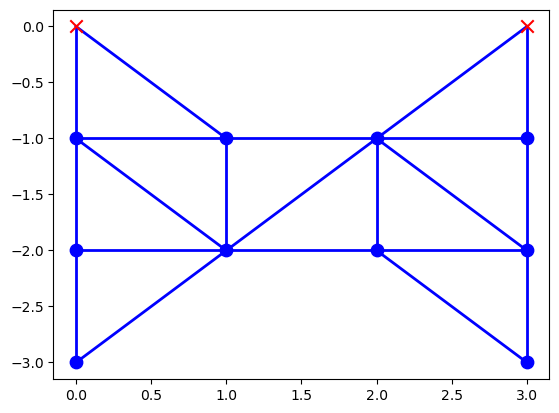

In [4]:
display.plot_truss(t)

## peak power minimization without in-phase assumption
In Heidari's paper, the authors have derived an equivalent form of the peak power minimization:
\begin{equation}\label{eqn:peak_heidari}
	\begin{split}
		\underset{a}{\min} ~&~ \frac{1}{4}\left((f_R+f_I)^T(K(a)-\omega^2M(a))^{-1}(f_R-f_I)\right)^2+\left(f_R^T(K(a)-\omega^2M(a))^{-1}f_I\right)^2\\
		\text{ s.t. }&\left\{\begin{array}{l}
			a^Tq\leq m, a\geq 0\\
			K(a)-\omega^2M(a)\succ 0
		\end{array}\right.
	\end{split}
\end{equation}
By "in-phase" assumption, this problem is reduced to linear SDP programming. We will use the short notation $K_\omega(a)=-\omega^2M(a)+K(a)$ for the following discussion. In my notes, I have proposed a way to eliminate the "in-phase assumption" : 
\begin{equation}
	\begin{split}
		\underset{a,X}{\min} ~&~ \frac{1}{4}\text{tr}\left\{\begin{pmatrix}1&0\\0&-1\end{pmatrix}X\right\}^2+\frac{1}{4}\text{tr}\left\{\begin{pmatrix}0&1\\1&0\end{pmatrix}X\right\}^2\\
		\text{ s.t. }&\left\{\begin{array}{l}
			a^Tq\leq m, a\geq 0\\
			K(a)-\omega^2M(a)\succ 0\\
			X=F^TK_\omega(a)^{-1}F			
		\end{array}\right.
	\end{split}
\end{equation}
By the use of variable $X$ and constraint $X=F^TK_\omega(a)^{-1}F$ which is relaxed by $X\succeq F^TK_\omega(a)^{-1}F$. The matrix $F$ has two columns $f_R$ and $f_I$. After relaxation we identity $X=(x_{00},x_{01},x_{11})$ as a $3$ dimension vector. We note that the objective function is positve and quadratic with respect to $X$ thus it is SDP representable. We propose the following minimization problem:\begin{equation}
	\begin{split}
		\underset{a,(x_{00},x_{01},x_{11}),\theta}{\min} ~&~ \theta\\
		\text{ s.t. }&\left\{\begin{array}{l}
			a^Tq\leq m, a\geq 0\\
			\begin{pmatrix}
				\begin{matrix}x_{00}&x_{01}\\x_{01}&x_{11}\end{matrix} & F^T\\
				F & K_\omega(a)
			\end{pmatrix}\succeq 0\\
			\begin{pmatrix}\theta&x_{00}-x_{11}&x_{01}\\x_{00}-x_{11}&4&\\x_{01}&&1\end{pmatrix}\succeq 0	
		\end{array}\right.
	\end{split}
\end{equation}
After solving this problem, $\sqrt{\theta}\omega$ gives a lower bound of the minimal peak power. 

Let's implement this with picos.

In [5]:
#build time varying loads (without in-phase assumption)
f_R = np.zeros(2*nodes.Nn)
f_R[10*2+1:10*2+5:2]=np.sqrt(np.ones(2)*0.5)
f_R = pc.Constant(f_R[nodes.dof])

f_I = np.zeros(2*nodes.Nn)
f_I[10*2:10*2+4:2]=np.array([np.sqrt(0.5),-np.sqrt(0.5)])
f_I = pc.Constant(f_I[nodes.dof])

#assemble matrices K and M as picos expression
t.assemble()

#this function computes the peak power at a given configuration of the truss
def get_peak_power(F, K_omega, omega):
    #compute the peak_power at given K_omega
    FTKF = F.T@np.linalg.inv(K_omega)@F

    C0 = np.array([[1,0],[0,-1]])
    C1 = np.array([[0,1],[1,0]])

    return omega/2*np.sqrt(np.trace(C0@FTKF)**2+np.trace(C1@FTKF)**2)

In [6]:
#get optimization variables and create expressions for later use
a = t.a
theta = pc.RealVariable("theta")
X = pc.SymmetricVariable("X",2)

K = t.K
M = t.M
K_omega = -omega**2*M+K
F = (f_R & f_I)

total_mass = (a | t.lengths*t.rho) # (|) for dot product

LMI1 = (X & F.T ) // (F & K_omega) # & and // for horizontal and vertical stacking
LMI2 = (theta & X[0,0]-X[1,1] & X[0,1]) // (X[0,0]-X[1,1] & 4 & 0) // (X[0,1] & 0 & 1)

In [7]:
#we compute the peak power of the uniform truss under given load
t.a.value = np.ones(t.elements.Ne)
total_mass_np = total_mass.np # being an expression of a, we can compute its value once a is specified
t.a.value /= total_mass_np #rescale to verify total mass constraint
peak_power_uniform = get_peak_power(F.np, K_omega.np, omega)
print(f"Peak power at uniform truss: {peak_power_uniform: e}")

Peak power at uniform truss:  5.614790e-02


Let's implement the minimization problem with picos.

In [8]:
peak_power_min = pc.Problem()
peak_power_min.set_objective("min",theta)

cons = peak_power_min.add_constraint(a>=0)
cons = peak_power_min.add_constraint(total_mass<=m)
cons = peak_power_min.add_constraint(LMI1>>0)
cons = peak_power_min.add_constraint(LMI2>>0)
print(peak_power_min)

Semidefinite Program
  minimize theta
  over
    1×1 real variable theta
    21×1 real variable a
    2×2 symmetric variable X
  subject to
    a ≥ 0
    ⟨a, [21×1]⟩ ≤ 1
    [X, [20×1, 20×1]ᵀ; 20×1, 20×1, -225·(a[0]·[20×20] + a[1]·[20×20] +
      a[2]·[20×20] + a[3]·[20×20] + a[4]·[20×20] + a[5]·[20×20] +
      a[6]·[20×20] + a[7]·[20×20] + a[8]·[20×20] + a[9]·[20×20] +
      a[10]·[20×20] + a[11]·[20×20] + a[12]·[20×20] + a[13]·[20×20] +
      a[14]·[20×20] + a[15]·[20×20] + a[16]·[20×20] + a[17]·[20×20] +
      a[18]·[20×20] + a[19]·[20×20] + a[20]·[20×20]) + a[0]·[20×20] +
      a[1]·[20×20] + a[2]·[20×20] + a[3]·[20×20] + a[4]·[20×20] +
      a[5]·[20×20] + a[6]·[20×20] + a[7]·[20×20] + a[8]·[20×20] +
      a[9]·[20×20] + a[10]·[20×20] + a[11]·[20×20] + a[12]·[20×20] +
      a[13]·[20×20] + a[14]·[20×20] + a[15]·[20×20] + a[16]·[20×20] +
      a[17]·[20×20] + a[18]·[20×20] + a[19]·[20×20] + a[20]·[20×20]] ≽
      0
    [theta, X[0,0] - X[1,1], X[0,1]; X[0,0] - X[1,1], 4, 0; X[0,1],

We solve the problem with cvxopt.

Peak power at uniform truss:  5.614790e-02
Lower bounds of the minimal peak power:  1.109867e-07
Actual peak power : 1.621046e+01


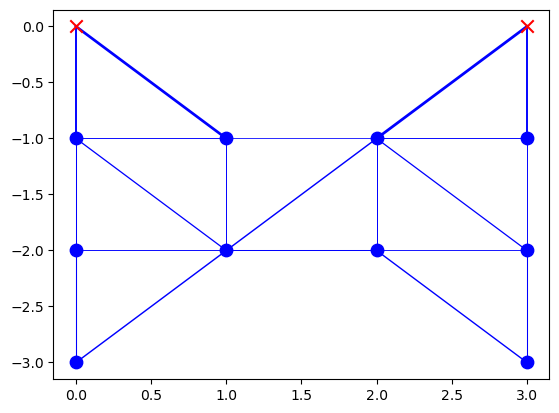

Total mass use : 3.943083e-03


In [9]:
sol = peak_power_min.solve(solver="cvxopt")
actual_peak_power = get_peak_power(F.np, K_omega.np, omega)

print(f"Peak power at uniform truss: {peak_power_uniform: e}")
print(f"Lower bounds of the minimal peak power: {np.sqrt(theta.value)/2 : e}")
print(f"Actual peak power :{actual_peak_power : e}")

display.plot_truss(t)
print(f"Total mass use : {total_mass.np :e}")

In fact the relaxation is "too strong", it gives a lower bound that is meaningless. The optimization converges to something that is worse than the uniform configuration ! Let's take a look at $X$ and $F^TK_{\omega}(a)^\dagger F$ at the optimal solution, they are expected to be near. Furthermore, the structure does not use all the available mass.

In [10]:
print(X.np)
print(F.np.T@np.linalg.inv(K_omega.np)@F.np)

[[5.80211651e+00 7.96148700e-08]
 [7.96148700e-08 5.80211665e+00]]
[[ 0.83400045 -0.7451933 ]
 [-0.7451933   2.39936831]]


This is not the case as we can see. In fact the optimization managed to minimize the function as we can see that $x_{00}$ is very closed to $x_{11}$ and $x_{01}$ is almost $0$. We need to control $X$ so that it's not "too far away" from $F^TK_{\omega}(a)^\dagger F$.

## penalized relaxation

To control $X$ by above, we consider the following problem with a penalization coefficient $\eta>0$:
\begin{equation}
	\begin{split}
		\underset{a,X,\theta}{\min} ~&~ \theta+\eta \text{tr}X\\
		\text{ s.t. }&\left\{\begin{array}{l}
			a^Tq\leq m, a\geq 0\\
			\begin{pmatrix}
				X & F^T\\
				F & K_\omega(a)
			\end{pmatrix}\succeq 0\\
			\begin{pmatrix}\theta&x_{00}-x_{11}&x_{01}\\x_{00}-x_{11}&4&\\x_{01}&&1\end{pmatrix}\succeq 0	
		\end{array}\right.
	\end{split}
\end{equation}
when $\eta$ is zero we goes back to the original relaxation problem. Let's implement this with a given $\eta$.

In [11]:
eta = 1.
pen_peak_power_min = pc.Problem()
pen_peak_power_min.set_objective("min",theta+eta*pc.trace(X))

cons = pen_peak_power_min.add_constraint(a>=0)
cons = pen_peak_power_min.add_constraint(total_mass<=m)
cons = pen_peak_power_min.add_constraint(LMI1>>0)
cons = pen_peak_power_min.add_constraint(LMI2>>0)

In [12]:
#Solution of the penalized relaxtion of the peak power minimization
sol = pen_peak_power_min.solve(solver="cvxopt")
actual_peak_power = get_peak_power(F.np, K_omega.np, omega)
print(f"Peak power at uniform truss: {peak_power_uniform: e}")
print(f"Actual peak power :{actual_peak_power : e}")
print(f"total mass use :{total_mass.np:e}")

Peak power at uniform truss:  5.614790e-02
Actual peak power : 4.321302e-02
total mass use :1.000000e+00


We get actually a configuration that is better (in terms of the peak power performance) than uniform truss and let's see what is $X$ and $F^TK_{\omega}(a)^\dagger F$ at the optimal solution.

In [13]:
print(X.np)
print(F.np.T@np.linalg.inv(K_omega.np)@F.np)

[[ 0.00220506 -0.00165184]
 [-0.00165184  0.00692558]]
[[ 0.00220506 -0.00165184]
 [-0.00165184  0.00692558]]


They coincide. So this idea of penalization has a hope to work. Now let's see the influence of $\eta$ on the peak power performance of the solution of penalized minimization.

In [14]:
peak_power_perf = []
trace_opt = []
theta_opt = []
a_opt = []

eta = 10.**np.linspace(-6,-3.5,80)
for e in eta:
    pen_peak_power_min.set_objective("min",theta+e*pc.trace(X))
    sol = pen_peak_power_min.solve(solver="cvxopt")
    trace_opt.append(np.trace(X.np))
    theta_opt.append(theta.np)
    actual_peak_power = get_peak_power(F.np, K_omega.np, omega)
    peak_power_perf.append(actual_peak_power)
    
    a_opt.append(a.np)

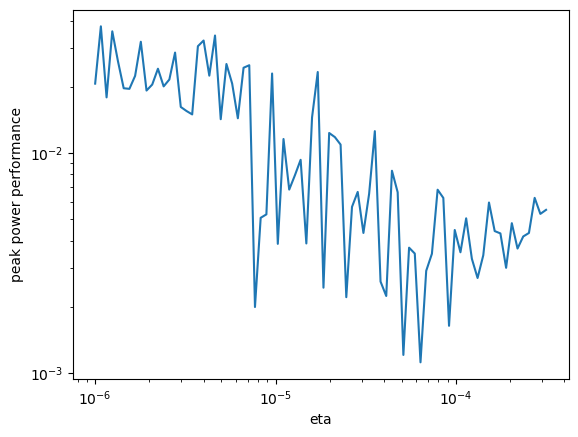

In [15]:
plt.plot(eta, peak_power_perf)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("eta")
plt.ylabel("peak power performance")
plt.show()

In [16]:
print(f"Best peak power performance : {min(peak_power_perf) : e}")
print(f"Peak power at uniform truss: {peak_power_uniform: e}")

a_best_eta = a_opt[np.argmin(peak_power_perf)] #keep the design that gives the best peak power performance

Best peak power performance :  1.116972e-03
Peak power at uniform truss:  5.614790e-02


In the compliance minimization, the compliance $c$ can be represented by the lmi : 
\begin{equation}
    \begin{pmatrix}
        c & f^T \\
        f & K(a)
    \end{pmatrix}\succeq 0
\end{equation}
When we have multiple load cases $f_j$, each of the compliance $c_j$ can be represented by:
\begin{equation}
    \begin{pmatrix}
        c_j & f_j^T \\
        f_j & K(a)
    \end{pmatrix}\succeq 0
\end{equation}
However, we can also put $f_j$ in a matrix $F=(f_j)$, so each of the column of $F$ is the load case $f_j$. Then we might consider a matrix variable $X$ such that:
\begin{equation}
    \begin{pmatrix}
        X & F^T \\
        F & K(a)
    \end{pmatrix}\succeq 0
\end{equation}
so we read the compliance from the diagonal elements of $X$ if there is equality $X=F^TK(a)^\dagger F$. The penalty $\eta \text{tr}X$ of penalized minimization of peak power corresponds to the dynamic compliance since we have:
\begin{equation}
    \begin{pmatrix}
        X & F^T \\
        F & K_\omega(a)
    \end{pmatrix}\succeq 0
\end{equation}
where the "off-phase" loads $f_R$ and $f_I$ are considered separately. When $\eta$ is large, the penalized minimization of peak power tends to yield a design configuration that minimizes the dynamic compliance. In fact we can observe this by taking large $\eta$ in the previous experiments.

In [17]:
peak_power_perf = []
trace_opt = []
theta_opt = []

eta = 10.**np.linspace(-4,0,80)
for e in eta:
    pen_peak_power_min.set_objective("min",theta+e*pc.trace(X))
    sol = pen_peak_power_min.solve(solver="cvxopt")
    trace_opt.append(np.trace(X.np))
    theta_opt.append(theta.np)
    actual_peak_power = get_peak_power(F.np, K_omega.np, omega)
    peak_power_perf.append(actual_peak_power)
    
a_compl = a.np

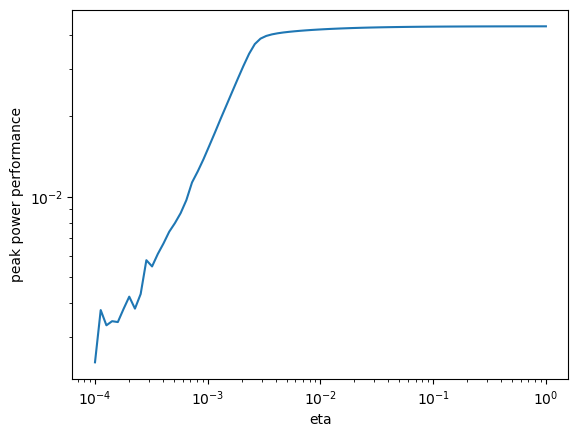

In [18]:
plt.plot(eta, peak_power_perf)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("eta")
plt.ylabel("peak power performance")
plt.show()

From the previous plot we can see that the peak power performance tends to a fixed value when $\eta$ is large, it suggests that the design tends to a fixed configuration. We also note that the design at the best $\eta$ is near to the minimal dynamic compliance design.

In [19]:
print(f"distance between best eta design and minimal dynamic compliance design : {np.linalg.norm(a_compl - a_best_eta) : e}")

distance between best eta design and minimal dynamic compliance design :  2.475582e-02


This experiment suggests that the penalized relaxation, at the best eta, tends to give a sub-optimal solution of the peak power minimization that is near the minimal dynamic compliance design. And we know that the minimal dynamic compliance design under truss assemption is unique when we imposed the condition $-\omega^2M(a)+K(a)\succeq 0$.

We might try to apply Newton step to solve directly the unrelaxed minimization problem
\begin{equation}
	\begin{split}
		\underset{a,X}{\min} ~&~ \frac{1}{4}\text{tr}\left\{\begin{pmatrix}1&0\\0&-1\end{pmatrix}X\right\}^2+\frac{1}{4}\text{tr}\left\{\begin{pmatrix}0&1\\1&0\end{pmatrix}X\right\}^2\\
		\text{ s.t. }&\left\{\begin{array}{l}
			a^Tq\leq m, a\geq 0\\
			K(a)-\omega^2M(a)\succ 0\\
			X=F^TK_\omega(a)^{-1}F			
		\end{array}\right.
	\end{split}
\end{equation}
by taking the minimal dynamic compliance design as initial point.

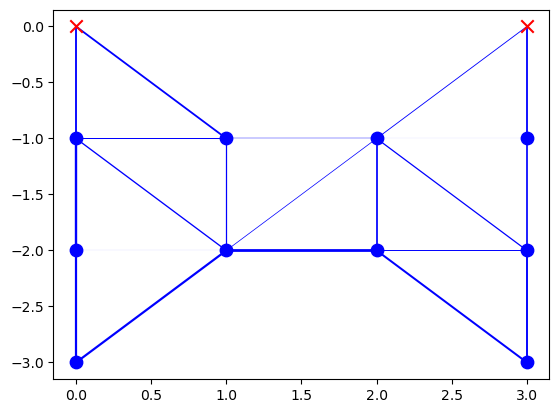

In [20]:
a.value = a_compl
display.plot_truss(t)

In [21]:
# resonance frequencies at dynamic compliance solution
print(sp.linalg.eigvalsh(K.np,M.np))

[   234.81887081    843.34064708   1056.18655742   1643.3125406
   2632.36348321   2907.59376256   4847.32074475   8715.72084973
  12080.05751332  17988.20319361  24800.44248811  28981.9631771
  39212.49709987  43277.55671886  44448.23090875  53642.86206377
  70167.44108738  91246.9562046  132342.54182995 163477.79076409]


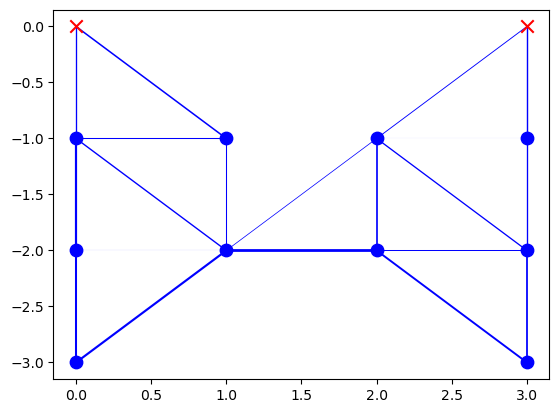

In [22]:
a.value = a_best_eta
display.plot_truss(t)

In [23]:
# resonance frequencies at best eta solution
print(sp.linalg.eigvalsh(K.np,M.np))

[   226.19368072    826.04488072   1059.87035573   1562.17570892
   2307.69276996   2418.57099944   4421.93090747   6713.97601925
  12517.81568775  18527.21708362  23542.52506812  29878.94549755
  39289.89078699  43261.55561043  45084.19421725  54374.61422387
  70539.70328576  92318.01482651 126884.70044475 161863.39368103]
